# Project Title

## Import

In [ ]:
# Install required packages
%pip install -qU bs4
%pip install -qU chromadb
%pip install -qU tiktoken
%pip install -qU langchain
%pip install -qU langgraph
%pip install -qU langchainhub
%pip install -qU tavily-python
%pip install -qU "nomic[local]"
%pip install -qU langchain-nomic
%pip install -qU langchain-ollama
%pip install -qU langchain_community


In [ ]:
# Import
import os
import re
import getpass
import operator
import requests

from bs4 import BeautifulSoup
from urllib.parse import urljoin
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display
from typing import Annotated, List, Literal

# from langchain import hub
from langchain.schema import Document
from langchain_ollama import ChatOllama
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import START, END, StateGraph

import warnings
warnings.filterwarnings("ignore")


In [3]:
## Constants

# The base URL and the webpage to crawl
ITA_HOMEPAGE_URL = "https://www.italia.it/en"       # WebPage for Data extraction 
EN_BASE_URL = "https://www.italia.it/en"   # Base URL address for crawling internal URLs 

# Regions List for URLs
REGIONS = ["abbruzzo", "aosta-valley", "puglia", "basilicata", "calabria", "campania", "emilia-romagna", "friuli-venezia-giulia", "lazio", "liguria", "lombardy", "marche", "piedmont", "sardinia", "trentino", "south-tyrol", "tuscany", "umbria", "veneto"] 


## Setup

In [4]:
# Setup environment 
def _set_env(key: str) -> None:
    """
    Set the environment variables.
        Args:
            key (str): The name of the environment variable.
    """
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"Enter {key}:")

# _set_env("LANGCHAIN_API_KEY")
_set_env("NOMIC_API_KEY")
_set_env("TAVILY_API_KEY")

# LangChain key: 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
# Nomic key: nk-2lWlK26_eyFeHHN8bAA4tiIaqEJNjJ8vCGkIlnBiz1M
# Tavily key: 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


In [5]:
# LLM 
local_llm = "llama3.2"  
llm = ChatOllama(model=local_llm, temperature=0)

# Initialize Tavily web search tool
tavily_web_search = TavilySearchResults(max_results=3)


In [255]:
# retrieve internal links from a webpage 
def get_internal_links(website_url, base_url):
    """
        Retrieves internal links from the given webpage URL that start with the base URL.
    
        Args:
        - website_url (str): The URL of the webpage to crawl.
        - base_url (str): The base URL to filter internal links (e.g., "https://www.italia.it/en").
    
        Returns:
        - list[str]: A list of internal URLs that begin with the base URL.
    """
    # Send a request to the website
    response = requests.get(website_url)
    
    # Parse the content of the webpage
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Set of internal links
    internal_links = set()
    
    # Find all <a> tags with href attributes
    for link in soup.find_all("a", href=True):
        # Convert relative URLs to absolute URLs
        href = urljoin(base_url, link["href"])
        
        # Check if the URL starts with the base URL
        if href.startswith(base_url):
            internal_links.add(href)
    
    return list(internal_links)


# Get the internal URLs
urls = get_internal_links(website_url=ITA_HOMEPAGE_URL, base_url=EN_BASE_URL)

# # Print the list of internal URLs
# for url in urls:
#     print(url)


# # List to store internal URLs from all regions
# urls = []
# 
# # Craw internal URLs
# for region in REGIONS:
#     # Dynamically create the base URL for each region
#     base_url = f"{italian_url}/{region}"
# 
#     # Get internal URLs for the specific region
#     internal_urls = get_internal_links(base_url, base_url)
# 
#     # Add the retrieved URLs to the overall list
#     urls.extend(internal_urls)
# 
# counter = 0
# # Print all internal URLs from all regions
# for internal_url in all_internal_urls:
#     counter += 1
#     print(internal_url)
# 
# print(f"Counter: {counter}")


## Vectorstore

In [ ]:
# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)

# Set embeddings
embeddings = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")

# Add to vectorstore
vectorstore = Chroma.from_documents(documents=doc_splits, embedding=embeddings)

In [99]:
# Create retriever
retriever = vectorstore.as_retriever(k=3, search_type="similarity")


In [ ]:
# Test retriever
retriever.invoke("Duomo")


### Router

In [256]:
## Router
class QueryRoute(BaseModel):
    """
      Route a user query to the most relevant datasource -> vectorstore or websearch.
    """
    datasource: Literal["vectorstore", "web_search"] = Field(
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM
structured_llm_router = llm.with_structured_output(QueryRoute)

# System prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to some famous italian city, touristic and historical places, food and travel tips for tourists.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# Combine the system message and user question in a prompt template
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_instructions),
        ("human", "{question}"),
    ]
)
question_router = route_prompt | structured_llm_router


In [257]:
## Test router
# expected result: vectorstore
print(question_router.invoke({"question": "Where is the Colosseum?"}))
# expected result: web_search
print(question_router.invoke({"question": "What is the capital of France?"}))


datasource='vectorstore'
datasource='web_search'


### Relevance

In [258]:
# Docs are relevant or not
class GradeDocs(BaseModel):
    """
        Binary score for relevance check on retrieved documents.
    """
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM
structured_llm_retrieval = llm.with_structured_output(GradeDocs)

# Prompt
doc_grader_instructions = """
You are a grader assessing relevance of a retrieved document to a user question.  
If the document contains keyword(s), shares concepts or semantic meaning related to the user question, grade it as relevant. 
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", doc_grader_instructions),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
retrieval_grader = grade_prompt | structured_llm_retrieval


In [265]:
## Test grader
# First question: expected score = yes
question_1 = "Where is the Colosseum located?" 
retrieve_document_1 = retriever.invoke(question_1)
docs_text_1 = retrieve_document_1[0]
print(retrieval_grader.invoke({"question": question_1, "document": docs_text_1}))

# Second question: expected score = no
question_2 = "Who won the olympics 2024?"   
retrieve_document_2 = retriever.invoke(question_2) 
docs_text_2 = retrieve_document_2[0]
print(retrieval_grader.invoke({"question": question_2, "document": docs_text_2}))


binary_score='yes'
binary_score='no'


In [ ]:
# ## Generate
# 
# # Prompt 
# rag_prompt = hub.pull("rlm/rag-prompt")
# # rag_prompt.pretty_print()
# 
# # Post-processing
# def format_docs(documents):
#     return "\n\n".join(doc.page_content for doc in documents)
# 
# # Chain
# rag_chain = rag_prompt | llm | StrOutputParser()


In [ ]:
# # Generator execution example
# generate_answer = rag_chain.invoke({"context": relevant_document_1, "question": "Where is the fountain of Trevi?"})
# print(generate_answer)


### Planning

In [266]:
# Prompt
planner_instructions = """
You are an expert travel planner with a kind and friendly personality. Always start the conversation by saying hello. You're excited to help travelers plan their perfect vacation with engaging and heartfelt recommendations. Present the information as if you are talking to a friend, making sure to be warm, conversational, and enthusiastic about the places to visit, the local cuisine, and tips for the trip. Make it feel like a personal guide. Don't be concise, but be conversational.

Question: {question}
Context: {context}

Plan:
- **Places to Visit**: 
    Start by warmly describing the main attractions, what makes them special, and why they're must-sees. Use friendly language like "You’ll love visiting..." or "Make sure to check out..."
    
- **Local Cuisine**: 
    Describe the local dishes with enthusiasm, like you're sharing a favorite meal with a friend. Phrases like "You can't leave without trying..." or "One bite of this and you'll see why it's a local favorite..." will make it feel personal.

- **Tips for Travelers**: 
    Offer helpful advice as if you're giving insider knowledge, with kind reminders like "Don’t forget to bring..." or "It's always good to know that..."

End with a friendly closing note like: "I hope you have an amazing time! Safe travels!"
"""

planner_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", planner_instructions),
        ("human", "Question: \n\n {question}"),
    ]
)
plan_chain = planner_prompt | llm | StrOutputParser()


In [54]:
# # Post-processing
# def format_docs(documents):
#     """
#     Formats and cleans the page contents of documents into a single string.
# 
#     Args:
#         documents (list): A list of document objects, each containing a 'page_content' attribute.
# 
#     Returns:
#         str: A single cleaned string containing the combined page contents,
#               with excessive whitespace removed.
#     """
#     # Combine page contents
#     combined_text = "\n\n".join(doc.page_content for doc in documents)
# 
#     # Clean the combined text by removing excessive whitespace
#     cleaned_text = re.sub(r'\s+', ' ', combined_text).strip()
#     
#     return cleaned_text


In [267]:
# Test planner
planner_question = "What kind of places can I visit while in Rome?"
retrieved_docs_for_planner = retriever.invoke(planner_question)
generated_plan = plan_chain.invoke({"context": retrieved_docs_for_planner, "question": planner_question})
print(generated_plan)


Hello! I'm so excited to help you plan your trip to Rome. This city is truly one of the most incredible destinations on earth, with a rich history, stunning architecture, and a vibrant culture that will leave you wanting more.

First of all, let's talk about some of the must-see places in Rome. You'll love visiting the Colosseum, the largest amphitheater in the Roman Empire, which is an absolute marvel of engineering and history. It's like stepping back in time to ancient Rome, where gladiators once fought for their lives. Make sure to check out the Roman Forum, too, which is a sprawling archaeological site filled with ancient ruins, temples, and basilicas.

Another iconic landmark you won't want to miss is the Pantheon, a magnificently preserved temple that's been standing since 126 AD. Its stunning dome is one of the greatest architectural achievements in history, and it's still an awe-inspiring sight today.

Of course, no trip to Rome would be complete without visiting the Vatican C

### Check for hallucination

In [268]:
# Hallucination Grader
class GradeHallucinations(BaseModel):
    """
        Binary score for hallucination present in generation answer.
    """

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )
    
# LLM
structured_llm_hallucination = llm.with_structured_output(GradeHallucinations)

# Prompt
hallucination_grader_instructions = """
You are a grader assessing whether the travel planner is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

hallucination_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_grader_instructions),
        ("human", "Set of facts: \n\n {documents} \n\n Travel planner: {planner}"),
    ]
)
hallucination_grader = hallucination_grader_prompt | structured_llm_hallucination


In [274]:
# Test hallucination grader
hallucination = hallucination_grader.invoke({"documents": retrieved_docs_for_planner[0], "planner": generated_plan})
print(hallucination)


binary_score='yes'


### Answer evaluation

In [275]:
# Answer Grader
class GradeAnswers(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )
    
# LLM
structured_llm_grader = llm.with_structured_output(GradeAnswers)

# Prompt
answer_grader_instructions = """
You are a grader assessing whether the planner addresses / resolves a request
Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the request."""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_instructions),
        ("human", "User question: \n\n {question} \n\n Planner: {planner}"),
    ]
)
answer_grader = answer_prompt | structured_llm_grader


In [276]:
# Test answer grader
answer_grader.invoke({"question": planner_question, "planner": generated_plan})


GradeAnswers(binary_score='yes')

### Re-write query

In [277]:
# Prompt
re_write_instructions = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", re_write_instructions),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)
question_rewriter = re_write_prompt | llm | StrOutputParser()


In [278]:
# Test question re-writer 
question_rewriter.invoke({"question": planner_question})


'Improved Question:\n"What are some popular tourist attractions, landmarks, historical sites, and cultural institutions that I can visit during my stay in Rome?"\n\nReasoning:\n\n1. **Added specificity**: By specifying "tourist attractions", "landmarks", "historical sites", and "cultural institutions", the question becomes more targeted towards specific types of places to visit.\n2. **Inclusion of duration**: Adding "during my stay" implies that the user is looking for suggestions for their entire trip, rather than just a single day or activity.\n3. **More descriptive language**: Using phrases like "popular tourist attractions" and "cultural institutions" provides more context about what the user is looking for, making it easier for the vectorstore to retrieve relevant results.\n\nThis improved question is better suited for vectorstore retrieval because it:\n\n* Uses more specific keywords related to tourism and travel\n* Includes a clear indication of the duration of the stay\n* Provi

# Tavily: web search tool

In [65]:
# Test Tavily 
tavily_web_search.invoke({"query": "What is LangGraph?"})


[{'url': 'https://www.langchain.com/langgraph',
  'content': 'LangGraph is a stateful, orchestration framework that brings added control to agent workflows. LangGraph Cloud is a service for deploying and scaling LangGraph applications, with a built-in Studio for prototyping, debugging, and sharing LangGraph applications.'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner. It simplifies the development process by enabling the creation of cyclical graphs, which are essential for developing'},
 {'url': 'https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787',
  'content': "LangGraph is a low-level framework that offers extensive customisation options, allowing you to build precisely what you need. Since

## Graph: State

In [318]:
# Graph's state
class State(TypedDict):
    """
    Represents the state of the graph.

    Attributes:
        documents: list of documents.
        max_retries: the maximum number of hallucination checks permitted.
        loop_step: Indicates the current step in a looping process.
        planner: LLM planning.
        question: question.
        web_search: run web search
    """
    documents: List[str]
    max_retries: int
    loop_step: Annotated[int, operator.add]
    planner: str
    question: str
    web_search: str
    

### Graph: Nodes

In [321]:
# Node: retrieve documents
def retrieve(state: State):
    """
        Retrieve documents from vectorstore
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    
    return {"documents": documents, "question": question}


# Node: docs are relevant or not
def grade_documents(state: State):
    """
        Determines whether the retrieved documents are relevant to the question.
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]    
    documents = state["documents"] 

    relevant_documents = []
    select_web= "no"
    
    for doc in documents:
        retrieval_score = retrieval_grader.invoke(
            {"question": question, "document": doc.page_content}
        )
        retrieval_grade = retrieval_score.binary_score
        
        if retrieval_grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            relevant_documents.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # set a flag to indicate that we want to run web search
            select_web = "yes"
            continue
       
    return {"documents": relevant_documents, "web_search": select_web}


# Node: make query great again
def transform_query(state: State):
    """
        Transform the query to produce a better question.
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    
    return {"question": better_question}


# Node: planning
def planner(state: State):
    """
        Generates a plan based on the provided query.
        
        Args:
            state (dict): The current graph state.
    
        Returns:
            state (dict): Updates planner key with the generated plan and
                the loop step, incremented by 1.
    """
    print("---PLANNER---")
    question = state["question"]            # get question state
    documents = state["documents"]          # get documents state
    loop_step = state.get("loop_step", 0)   # Init loop_step 
    
    # RAG planning
    make_plan = plan_chain.invoke({"context": documents, "question": question})
    
    return {"planner": make_plan, "loop_step": loop_step + 1}


# Node: search on the web
def web_search(state: State):
    """
    Web search based on the query.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]          
    documents = state.get("documents", []) 

    # Perform a web search using the Tavily
    web_docs = tavily_web_search.invoke({"query": question})
    web_results = "\n".join([doc["content"] for doc in web_docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    
    return {"documents": documents}
    

### Graph: Edges

In [326]:
# Edge: RAG or web
def route_question(state: State):
    """
        Route question to web search or RAG.
    
        Args:
            state (dict): The current graph state
    
        Returns:
            str: Next node to call
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    
    if source.datasource == "web_search": 
        print("---ROUTE QUESTION TO WEB SEARCH---")
        
        return "websearch"
    
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        
        return "vectorstore"
    

# Edge: planner or web_search
def decide_to_plan(state: State):
    """
    Determines whether start planning, or search answer on the web.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---EVALUATE GRADED DOCUMENTS---")
    question = state["question"]
    websearch = state["web_search"]
    filtered_documents = state["documents"]
    
    if websearch == "yes":  # Go to web
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        
        return "websearch"
    else:   # The docs are relevant
        print("---DECISION: PLANNER---")
        
        return "travel_planner"


# Edge: fact checking on docs
def grade_generation_v_documents_and_question(state: State):
    """
    Determines whether the planning is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    max_retries = state.get("max_retries", 3)
    plan = state["planner"]
    
    for doc in documents:
        hallucination_score = hallucination_grader.invoke(
            {"documents": doc, "planner": plan}
        )
        hallucination_grade = hallucination_score.binary_score
    
        # Check hallucination
        if hallucination_grade == "yes":
            print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
            # Check question-answering
            print("---GRADE GENERATION vs QUESTION---")
            answer_score = answer_grader.invoke({"question": question, "planner": plan})
            answer_grade = answer_score.binary_score
            
            if answer_grade == "yes":
                print("---DECISION: GENERATION ADDRESSES QUESTION---")
                return "useful"
            elif state["loop_step"] <= max_retries:
                print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
                return "not useful"
            else:
                print("---DECISION: MAX RETRIES REACHED ❌---")
                return "max retries"
        elif state["loop_step"] <= max_retries:
            print(f"---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
            return "check"
        else:
            print("---DECISION: MAX RETRIES REACHED ⚠️---") # web
            return "max retries"


### Build the graph

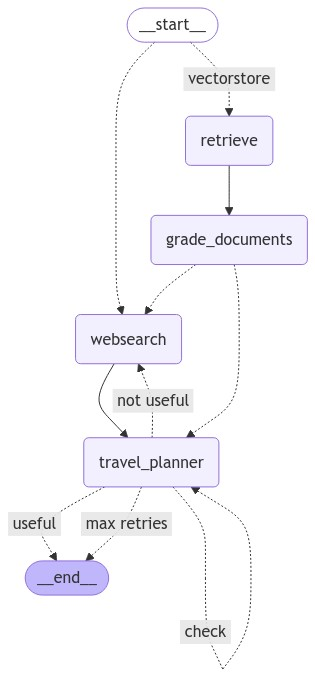

In [323]:
# Graph's state
workflow = StateGraph(State)

# Define the nodes
workflow.add_node(node="retrieve", action=retrieve)                 # retrieve
workflow.add_node(node="grade_documents", action=grade_documents)   # grade_documents
workflow.add_node(node="websearch", action=web_search)              # web_search
workflow.add_node(node="travel_planner", action=planner)            # travel_planner

# Build graph: edges and condition
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("websearch", "travel_planner")
workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_plan,
    {
        "websearch": "websearch",
        "travel_planner": "travel_planner",
    },
)

workflow.add_conditional_edges(
    "travel_planner",
    grade_generation_v_documents_and_question,
    {
        "check": "travel_planner",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
# Display the graph
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))


In [324]:
# Test Graph
answer = graph.invoke({"question": "What kind of food can I eat while in Florence?"})["planner"]
print(answer)


---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---EVALUATE GRADED DOCUMENTS---
---DECISION: PLANNER---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Florence, the culinary gem of Italy! You're in for a treat when it comes to delicious Tuscan cuisine. Here are some traditional Florentine dishes and foods you should try while visiting:

1. **Bistecca alla Fiorentina**: A thick, juicy T-bone steak served rare, often with beans and spinach.
2. **Ribollita**: A hearty soup made from vegetables, bread, and cannellini beans.
3. **Pappardelle al Cinghiale**: Wide, flat noodles served with a wild boar ragù.
4. **Cantucci con Vin Santo**: Almond biscuits dipped in Vin Santo, a sweet desser

In [327]:
# Test Graph
answer = graph.invoke({"question":"Where I can find the fountain of Trevi?"})["planner"]
print(answer)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---EVALUATE GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
---WEB SEARCH---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: MAX RETRIES REACHED ⚠️---
Hello! I'm so excited to help you plan your trip to Rome. You're looking for the famous Fountain of Trevi, and I just know you'll fall in love with it.

The Fountain of Trevi is located in the heart of Rome, in a beautiful piazza called Piazza di Trevi. It's one of the most iconic landmarks in the city, and it's a must-see when visiting Rome

In [328]:
# Test Graph: expected generation grounded in docs
answer = graph.invoke({"question":"Where I need to go while in Aosta-valley?"})["planner"]
print(answer)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---EVALUATE GRADED DOCUMENTS---
---DECISION: PLANNER---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Hello! I'm so excited to help you plan your trip to Aosta Valley. This beautiful region in northwest Italy is a treasure trove of natural wonders, rich history, and delicious local cuisine.

First, let's talk about the must-see attractions. You'll love visiting the iconic Matterhorn mountain, which towers above the town of Zermatt in Switzerland. But if you're looking for something closer to home, be sure to check out the charming town of Aosta itself, with its medieval old town and stunning views of the valley.

Another highlight is

In [329]:
# Test Graph: expected generation NOT grounded in docs
answer = graph.invoke({"question":"What kind of food I can eat while visiting Paris?"})["planner"]
print(answer)


---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: MAX RETRIES REACHED ⚠️---
Hello! Oh, I'm so excited to talk about the food in Paris! You're going to love it - it's truly one of the best culinary experiences you'll ever have. French cuisine is all about rich flavors, intricate preparations, and of course, exquisite presentation.

First of all, let's start with a classic: croque-monsieur. This is essentially a grilled ham and cheese sandwich that's been elevated to an art form in Paris. You can find it on menus everywhere, from cozy cafes to high-end restaurants. And trust me, you won't be disappointed - the combination of melted cheese, crispy bread, and savory ham is absolute perfection.

Another must-

## 